# Data Analysis

In [69]:
from gensim.corpora import Dictionary
from gensim.models import Phrases, TfidfModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.models.phrases import Phraser
# import math
from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
import pandas as pd
import pickle
import re
# from sklearn.cluster import KMeans
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.mixture import GaussianMixture

In [2]:
pd.options.mode.chained_assignment = None

In [3]:
REVIEWS = './data/cellphone_reviews.json'

## Utils

In [4]:
def flatten(lol):
    return [l for ll in lol for l in ll]

## Pre-processing

In [5]:
reviews = pd.read_json(REVIEWS, lines=True)
reviews['unhelpful'] = reviews['helpful'].apply(lambda x: x[1] - x[0])
reviews['helpful'] = reviews['helpful'].apply(lambda x: x[0])
reviews['reviewText'] = reviews['reviewText'].str.lower()
reviews.drop_duplicates(inplace=True)
reviews.head(5)

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,unhelpful
0,120401325X,0,4,they look good and stick good! i just don't li...,"05 21, 2014",A30TL5EWN6DFXT,christina,Looks Good,1400630400,0
1,120401325X,0,5,these stickers work like the review says they ...,"01 14, 2014",ASY55RVNIL0UD,emily l.,Really great product.,1389657600,0
2,120401325X,0,5,these are awesome and make my phone look so st...,"06 26, 2014",A2TMXE2AFO7ONB,Erica,LOVE LOVE LOVE,1403740800,0
3,120401325X,4,4,item arrived in great time and was in perfect ...,"10 21, 2013",AWJ0WZQYMYFQ4,JM,Cute!,1382313600,0
4,120401325X,2,5,"awesome! stays on, and looks great. can be use...","02 3, 2013",ATX7CZYFXI1KW,patrice m rogoza,leopard home button sticker for iphone 4s,1359849600,1
5,120401325X,1,3,these make using the home button easy. my daug...,"10 12, 2013",APX47D16JOP7H,RLH,Cute,1381536000,1
6,120401325X,0,5,came just as described.. it doesn't come unstu...,"08 22, 2013",A1JVVYYO7G56DS,Tyler Evans,best thing ever..,1377129600,0
7,3998899561,1,1,it worked for the first week then it only char...,"11 21, 2013",A6FGO4TBZ3QFZ,Abdullah Albyati,not a good Idea,1384992000,1
8,3998899561,2,5,"good case, solid build. protects phone all aro...","09 25, 2013",A2JWEDW5FSVB0F,Adam,Solid Case,1380067200,1
9,3998899561,1,5,this is a fantastic case. very stylish and pro...,"04 3, 2014",A8AJS1DW7L3JJ,Agata Majchrzak,Perfect Case,1396483200,0


### Filtering for negative reviews

In [6]:
negative_reviews = reviews.loc[reviews['overall'] <= 2]
negative_reviews.head(5)

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,unhelpful
7,3998899561,1,1,it worked for the first week then it only char...,"11 21, 2013",A6FGO4TBZ3QFZ,Abdullah Albyati,not a good Idea,1384992000,1
19,6073894996,0,1,it worked great for the first couple of weeks ...,"05 29, 2013",A2INSXDTE08WSJ,Barbie,Horrible,1369785600,0
26,6073894996,0,2,i am disappointed that the 1a didn't work with...,"06 23, 2014",A2YODGM5RUZ7I1,DCGeek1,This doesn't work with my iPad.,1403481600,0
28,6073894996,0,2,after a week only one side works,"07 3, 2014",A2U5NF3IH4YVKH,ebony winslow,Two Stars,1404345600,0
32,6073894996,0,1,only works one side at a time. when you connec...,"04 29, 2014",ASRM2FSLDPXVX,jose,"don't waste your money, pay more and buy one a...",1398729600,0
35,6073894996,0,2,didn't last very long. worked great when it wo...,"08 23, 2013",A30A04FS5YAES3,Levi Bowen,Works for a while.,1377216000,0
40,6073894996,0,2,i bought this so that i could use and charge m...,"05 5, 2012",A9VL5ER8D0K2Z,Owner,not high power,1336176000,0
44,6073894996,1,2,i could only give this usb car charger 2 stars...,"06 25, 2012",A5A4374R8I7NB,PWB Esq,"Works Fine, But It Died On ME",1340582400,0
46,6073894996,0,1,i bought 2 of this and tried to test first ......,"06 22, 2014",A25TQLMIAPI1T6,Ronaldo,Be careful,1403395200,0
63,7887421268,0,2,i loved the case when i first received it but ...,"08 6, 2012",A1PMGOX24BWDAZ,0902virgo,Loved it at first,1344211200,0


## Feature extraction

In [42]:
STOP_WORDS = set(stopwords.words('english'))
STOP_WORDS -= {'not', 'no'}

def tokenizer(sentence):
    tokens = [re.sub('[\W_]+', '', word) \
        for word in word_tokenize(sentence) \
            if len(word) > 2 and word not in STOP_WORDS]
    return tokens

def ngram(sent, n):
    """
    Splits a sentence into n-grams.
    """
    # Split sentence into words
    tokens = tokenizer(sent)
    # Zip n consecutive elements into tuples
    ngram_toks = zip(*[tokens[i:] for i in range(n)])
    # Concat
    ngrams = [' '.join(tok) for tok in ngram_toks]
    filtered_ngrams = [ngram for ngram in ngrams \
        if len(ngram) > 2]
    return filtered_ngrams

In [8]:
corpus = negative_reviews['reviewText'].values
all_sentences = flatten([sent_tokenize(review) for review in corpus])
all_valid_words = [tokenizer(sent) for sent in all_sentences]

### Building n-gram models

Abandoned because `gensim` is not giving any phrases, mostly unigrams.

In [9]:
# Check bigrams
bigrams = Phrases(all_valid_words, min_count=3)
bigram_mdl = Phraser(bigrams)
for avw in all_valid_words[:50]:
    print(bigram_mdl[avw])

['worked', 'first', 'week', 'charge', 'phone']
['waste_money']
['worked_great', 'first', 'couple_weeks', 'stopped', 'completely', 'basically', 'small', 'waste_money']
['disappointed', 'nt', 'work', 'ipad']
['get', 'buying', 'cheap', 'adapter']
['week', 'one', 'side', 'works']
['works', 'one', 'side', 'time']
['connect', 'two', 'cables', 'one', 'side', 'stop_working', 'also', 'overheated', 'burning', 'fuses']
['purchased', 'two', 'problem']
['cheap', 'bad', 'quality']
['nt', 'last_long']
['worked_great', 'worked', 'cheap', 'piece_plastic', 'crap', 'nt', 'expected', 'last']
['bought', 'could', 'use', 'charge', 'tab', 'time']
['tab', 'not', 'recognize', 'high', 'power', 'port', 'either', 'charge', 'use', 'power', 'not', 'charge', 'powered']
['could', 'give', 'usb', 'car_charger', 'stars', 'although', 'worked_fine', 'months', 'subsequently', 'died', 'mepros', 'has', 'usb_ports', 'charging', 'one', 'top', '21_amps']
['bottom', 'slot', 'lower', 'presumably', '15', 'ampsfits', 'well', 'chargi

### N-gram generation

In [43]:
negative_reviews.loc[:, 'reviewSents'] = negative_reviews['reviewText'] \
    .apply(sent_tokenize)
negative_reviews['unigrams'] = negative_reviews['reviewSents'] \
    .apply(lambda sents: flatten([ngram(sent, 1) for sent in sents]))
negative_reviews['bigrams'] = negative_reviews['reviewSents'] \
    .apply(lambda sents: flatten([ngram(sent, 2) for sent in sents]))
negative_reviews['ubgrams'] = negative_reviews['unigrams'] \
    + negative_reviews['bigrams']
negative_reviews['trigrams'] = negative_reviews['reviewSents'] \
    .apply(lambda sents: flatten([ngram(sent, 3) for sent in sents]))
negative_reviews['ngrams'] = negative_reviews['unigrams'] \
    + negative_reviews['bigrams'] \
    + negative_reviews['trigrams']
negative_reviews.head(5)

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,unhelpful,reviewSents,unigrams,bigrams,trigrams,ngrams,ubgrams
7,3998899561,1,1,it worked for the first week then it only char...,"11 21, 2013",A6FGO4TBZ3QFZ,Abdullah Albyati,not a good Idea,1384992000,1,[it worked for the first week then it only cha...,"[worked, first, week, charge, phone, waste, mo...","[worked first, first week, week charge, charge...","[worked first week, first week charge, week ch...","[worked, first, week, charge, phone, waste, mo...","[worked, first, week, charge, phone, waste, mo..."
19,6073894996,0,1,it worked great for the first couple of weeks ...,"05 29, 2013",A2INSXDTE08WSJ,Barbie,Horrible,1369785600,0,[it worked great for the first couple of weeks...,"[worked, great, first, couple, weeks, stopped,...","[worked great, great first, first couple, coup...","[worked great first, great first couple, first...","[worked, great, first, couple, weeks, stopped,...","[worked, great, first, couple, weeks, stopped,..."
26,6073894996,0,2,i am disappointed that the 1a didn't work with...,"06 23, 2014",A2YODGM5RUZ7I1,DCGeek1,This doesn't work with my iPad.,1403481600,0,[i am disappointed that the 1a didn't work wit...,"[disappointed, work, ipad, get, buying, cheap,...","[disappointed nt, nt work, work ipad, get buyi...","[disappointed nt work, nt work ipad, get buyin...","[disappointed, work, ipad, get, buying, cheap,...","[disappointed, work, ipad, get, buying, cheap,..."
28,6073894996,0,2,after a week only one side works,"07 3, 2014",A2U5NF3IH4YVKH,ebony winslow,Two Stars,1404345600,0,[after a week only one side works],"[week, one, side, works]","[week one, one side, side works]","[week one side, one side works]","[week, one, side, works, week one, one side, s...","[week, one, side, works, week one, one side, s..."
32,6073894996,0,1,only works one side at a time. when you connec...,"04 29, 2014",ASRM2FSLDPXVX,jose,"don't waste your money, pay more and buy one a...",1398729600,0,"[only works one side at a time., when you conn...","[works, one, side, time, connect, two, cables,...","[works one, one side, side time, connect two, ...","[works one side, one side time, connect two ca...","[works, one, side, time, connect, two, cables,...","[works, one, side, time, connect, two, cables,..."


## Topic Inference

### Estimating no. of topics (ngrams)

> **Note:** Decreasing `u_mass` coherence values for all models, 
  using `c_v` metric as measure instead. Also considered k-means
  based on TF-IDF, but that's "hard" clustering.

In [19]:
def get_best_model(texts, max_topics, step=1):
    dictionary = Dictionary(texts)
    lda_corpus = [dictionary.doc2bow(text) for text in texts]
    est_topics = range(2, max_topics + step, step)
    lda_mdls = []
    coh_vals = []
    for i in est_topics:
        lda_mdl = LdaModel(lda_corpus, num_topics=i, id2word=dictionary,
            passes=3, alpha=[0.01] * i, eta=[0.01] * len(dictionary.keys()))
        lda_mdls.append(lda_mdl)
        coh_mdl = CoherenceModel(model=lda_mdl, texts=texts, 
            corpus=lda_corpus, dictionary=dictionary, coherence='c_v')
        coh_vals.append(coh_mdl.get_coherence())
    plt.plot(est_topics, coh_vals)
    plt.xlabel('Number of topics')
    plt.ylabel('Coherence values')
    plt.title('Elbow curve')
    plt.show()
    best_mdl = None
    best_cv = 0
    for idx, cv in enumerate(coh_vals):
        if cv > best_cv:
            best_cv = cv
            best_mdl = lda_mdls[idx]
    return best_mdl

Ngram version has decreasing `c_v` coherence values, not useful in
determining topic number

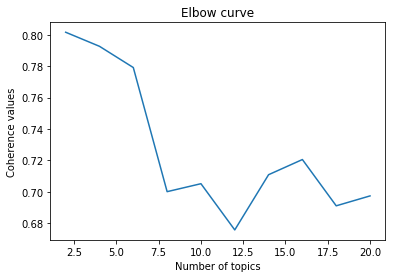

In [20]:
ngram_texts = list(negative_reviews['ngrams'].values)
best_ngram_model = get_best_model(ngram_texts, 20, 2)

Too little trigrams occur in multiple reviews, cannot infer topic
from topic words (overlaps).

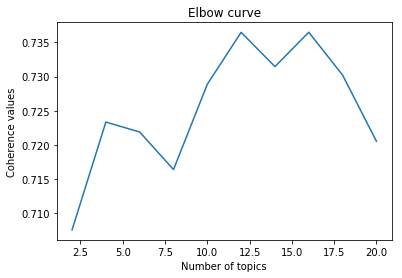

In [28]:
trigram_texts = list(negative_reviews['trigrams'].values)
best_trigram_model = get_best_model(trigram_texts, 20, 2)

A LDA model based on unigrams + bigrams with ~8 topics seems to be 
the best-performing model.

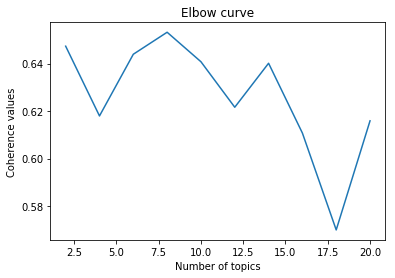

In [27]:
ubgram_texts = list(negative_reviews['ubgrams'].values)
best_ubgram_model = get_best_model(ubgram_texts, 20, 2)

Optimal number of clusters extending to beyond 20, but doesn't
seem realistic.

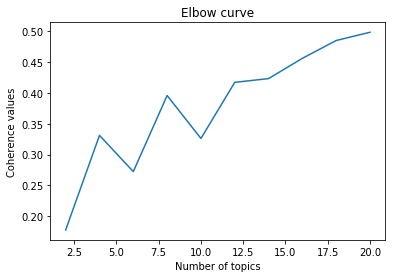

In [21]:
bigram_texts = list(negative_reviews['bigrams'].values)
best_bigram_model = get_best_model(bigram_texts, 20, 2)

Lower coherence values in general.

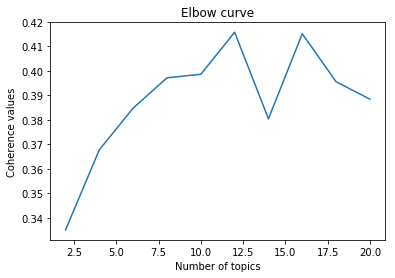

In [22]:
unigram_texts = list(negative_reviews['unigrams'].values)
best_unigram_model = get_best_model(unigram_texts, 20, 2)

### Looking at topic words

In [45]:
NUM_TOPICS = 8
ubgram_texts = list(negative_reviews['ubgrams'].values)
dictionary = Dictionary(ubgram_texts)
lda_corpus = [dictionary.doc2bow(text) for text in ubgram_texts]
best_lda_mdl = LdaModel(lda_corpus, num_topics=NUM_TOPICS, id2word=dictionary,
    passes=5, alpha=[0.01] * NUM_TOPICS, eta=[0.01] * len(dictionary.keys()))
best_lda_mdl.show_topics(num_topics=NUM_TOPICS, num_words=15)

[(0,
  '0.043*"not" + 0.016*"product" + 0.015*"money" + 0.013*"would" + 0.012*"buy" + 0.010*"cheap" + 0.009*"get" + 0.009*"time" + 0.009*"worth" + 0.008*"recommend" + 0.008*"waste" + 0.007*"one" + 0.007*"even" + 0.007*"first" + 0.006*"would not"'),
 (1,
  '0.007*"phone holder" + 0.007*"son" + 0.007*"nt provide" + 0.006*"8221" + 0.006*"samsung note" + 0.005*"sand" + 0.005*"would given" + 0.005*"matte finish" + 0.004*"certified" + 0.004*"grippy" + 0.004*"case thin" + 0.004*"provide protection" + 0.004*"closure" + 0.004*"continuous" + 0.003*"working one"'),
 (2,
  '0.028*"charge" + 0.025*"charger" + 0.022*"not" + 0.019*"charging" + 0.017*"cable" + 0.017*"phone" + 0.014*"work" + 0.011*"usb" + 0.011*"samsung" + 0.009*"power" + 0.008*"battery" + 0.008*"galaxy" + 0.007*"plug" + 0.007*"use" + 0.007*"iphone"'),
 (3,
  '0.047*"screen" + 0.022*"protector" + 0.018*"phone" + 0.015*"not" + 0.014*"screen protector" + 0.010*"get" + 0.008*"like" + 0.007*"protectors" + 0.006*"put" + 0.006*"bubbles" + 0.

In [65]:
best_lda_mdl.save('./reviews/model/lda_mdl.mm')

### Determining reasons

Manual topic labelling, still problems with topic quality

In [46]:
TOPIC_LABELS = {
    0: 'cheap product, waste of money',
    1: 'no protection',
    2: 'faulty charging cable',
    3: 'screen protector bubbles',
    4: 'lousy sound quality',
    5: 'does not work',
    6: 'poor battery life',
    7: 'case does not fit'
}

### Applying LDA Model

In [51]:
def review_topic(lda_mdl, dictionary, review_text):
    topic = None
    prob = 0
    for t, p in lda_mdl[dictionary.doc2bow(review_text)]:
        if p > prob:
            topic = t
    return topic

In [88]:
negative_reviews['topic_no'] = negative_reviews['ubgrams'] \
    .apply(lambda x: review_topic(best_lda_mdl, dictionary, x))
topic_freq = pd.DataFrame(negative_reviews \
    .groupby(['asin', 'topic_no'])['reviewText'] \
    .agg(['count', list]))
display(topic_freq.head(5))
topic_pcts = pd.merge(topic_freq, topic_freq.groupby(level=0)['count'] \
    .apply(lambda x: x / x.sum()).rename('perc'),
    left_index=True, right_index=True) \
    .reset_index()
topic_pcts['topic'] = topic_pcts['topic_no'] \
    .apply(lambda x: TOPIC_LABELS[x])
topic_pcts.head(5)

count                                               list
asin       topic_no                                                          
3998899561 2             1  [it worked for the first week then it only cha...
6073894996 2             1  [i bought this so that i could use and charge ...
           4             1  [it worked great for the first couple of weeks...
           5             4  [after a week only one side works, only works ...
           6             1  [i am disappointed that the 1a didn't work wit...

,asin,topic_no,count,list,perc,topic
0,3998899561,2,1,[it worked for the first week then it only cha...,1.000,faulty charging cable
1,6073894996,2,1,[i bought this so that i could use and charge ...,0.125,faulty charging cable
2,6073894996,4,1,[it worked great for the first couple of weeks...,0.125,lousy sound quality
3,6073894996,5,4,"[after a week only one side works, only works ...",0.500,does not work
4,6073894996,6,1,[i am disappointed that the 1a didn't work wit...,0.125,poor battery life


### Pickling output

In [91]:
review_dict = {}
for _, row in topic_pcts.iterrows():
    pdt_asin = str(row['asin'])
    pdt_dict = {'reason': row['topic'], 
        'frequency': row['perc'], 
        'reviews': row['list']}
    if pdt_asin not in review_dict:
        review_dict[pdt_asin] = [pdt_dict]
    else:
        review_dict[pdt_asin].append(pdt_dict)
with open('./reviews/saved_topics.pkl', 'wb') as out_pkl:
    pickle.dump(review_dict, out_pkl)